# Correlation Matrices

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

# load cstate data

In [3]:
from scripts.cell_state.normalize import normalize_cstate

# better normalize c state
if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")

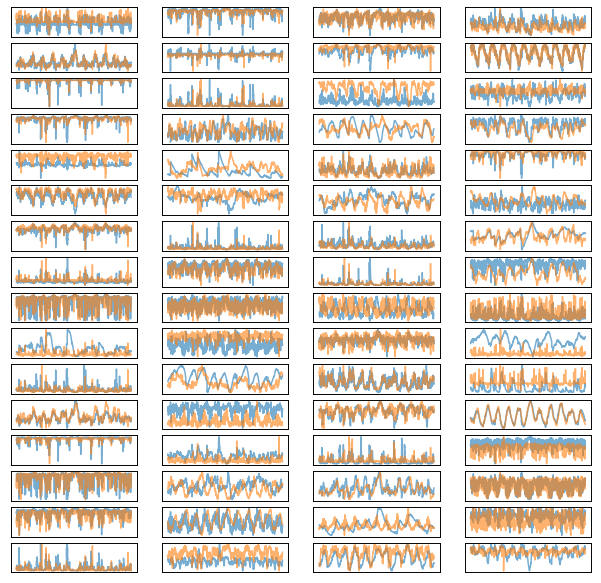

In [4]:
scale = 1.3
N_dims = 64
nrows = int(N_dims / 4)
ncols = 4
f, axs = plt.subplots(nrows, ncols, figsize=(2*scale*ncols, 0.5*scale*nrows))

pixels = np.random.choice(norm_cs_data.station_id.values, 2)

for ix in range(64):
    ax = axs[np.unravel_index(ix, (nrows, ncols))]
    for data_ix, pixel in enumerate(pixels):
        data = norm_cs_data.isel(dimension=ix). sel(station_id=pixel).to_dataframe()
        if data_ix == 1:
            ax2 = ax.twinx()
            ax2.plot(data.index, data["c_n"], alpha=0.6, color="C1")
            ax2.set_yticklabels([])
            ax2.set_yticks([])
        else:
            ax.plot(data.index, data["c_n"], alpha=0.6)
    ax.set_xticklabels([])
    ax.set_xticks([])
    
    ax.set_yticklabels([])
    ax.set_yticks([])

# load in esa ds

In [5]:
from scripts.cell_state.normalize import normalize_2d_dataset

filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
if not isinstance(esa_ds, xr.Dataset):
    esa_ds = esa_ds.to_dataset()

for var in esa_ds.data_vars:
    esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=False)

# filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
# if not filepath.exists():
#     esa_ds.to_netcdf(target_filepath)
# else:
#     esa_ds = xr.open_dataset(target_filepath)

In [6]:
esa_ds

<xarray.Dataset>
Dimensions:          (station_id: 670, time: 15036)
Coordinates:
  * time             (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2019-12-31
  * station_id       (station_id) int64 10002 10003 1001 ... 96002 96004 97002
Data variables:
    sm               (station_id, time) float64 nan nan nan ... 1.041 0.7772
    7_day_smooth_sm  (station_id, time) float64 nan nan nan ... 0.7043 0.7526

# Extract data as numpy arrays

In [7]:
from scripts.cell_state.analysis import calculate_raw_correlations
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples

In [8]:
cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
)

train_start_date = cs.time.min().values
train_end_date = pd.to_datetime("2006-09-30")
test_start_date = pd.to_datetime("2006-10-01")
test_end_date =  cs.time.max().values

input_variables = [v for v in cs.data_vars]

In [9]:
dataset = TimeSeriesDataset(
    input_data=cs,
    target_data=esa_ds,
    target_variable="sm",
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Train Samples",
)

# test_dataset = TimeSeriesDataset(
#     input_data=cs.sel(time=slice(test_start_date, test_end_date)),
#     target_data=esa_ds.sel(time=slice(test_start_date, test_end_date)),
#     target_variable="sm",
#     input_variables=input_variables,
#     seq_length=1,
#     basin_dim="station_id",
#     time_dim="time",
#     desc="Creating Test Samples",
# )

Creating Train Samples: 100%|██████████| 668/668 [00:09<00:00, 72.68it/s]


In [10]:
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples

X, y, times, station_ids = get_time_basin_aligned_samples(dataset)

Extracting Data: 100%|██████████| 10482/10482 [01:19<00:00, 132.08it/s]


Merging and reshaping arrays


# Correlation Matrix of X64 X64

In [81]:
from tqdm import tqdm

cross_corrs = np.empty(shape=(64, 64))
pbar = tqdm(np.arange(X.shape[-1]), desc="Calculating Correlation Matrices")

# NOTE: require for loop to prevent memory errors of loading massive matrix
for i in pbar:
    for j in np.arange(X.shape[-1]):
        pbar.set_postfix_str(f"Dimension: {j}")
        if i <= j:
            # upper triangular only (symmetrical)
            corr = np.corrcoef(X[:, i], X[:, j], rowvar=False)[0, 1]
            cross_corrs[i, j] = corr

Calculating Correlation Matrices: 100%|██████████| 64/64 [03:13<00:00,  3.03s/it, Dimension: 63]


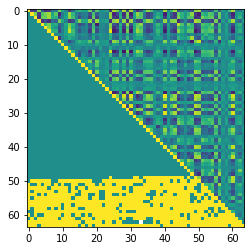

In [82]:
# make the matrix symmetric
# https://stackoverflow.com/a/42209263/9940782
corr_matrix = cross_corrs.copy()
corr_matrix = corr_matrix + corr_matrix.T - np.diag(np.diag(corr_matrix))

plt.imshow(cross_corrs, vmin=-1, vmax=1)

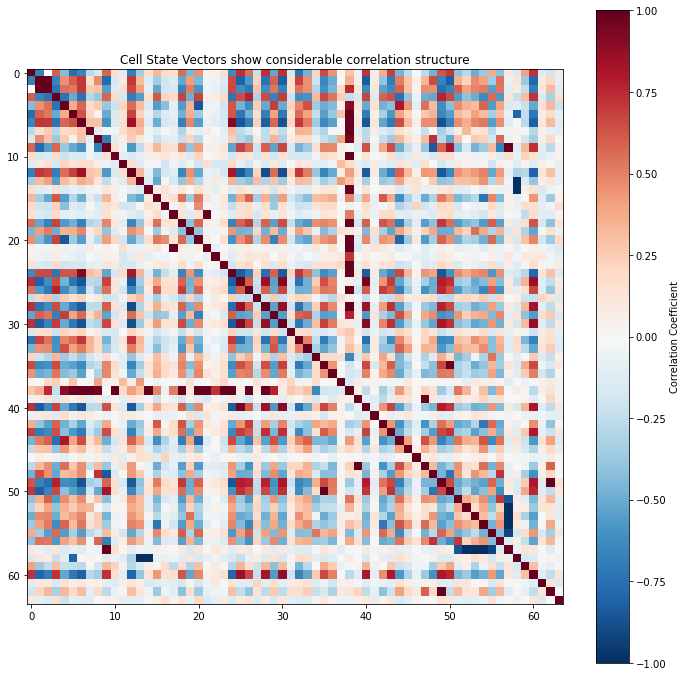

In [41]:
f, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(corr_matrix, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(im, label="Correlation Coefficient")

ax.set_title("Cell State Vectors show considerable correlation structure");

### Biclustering algorithm

In [71]:
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering

In [75]:
cluster = SpectralCoclustering(n_clusters=6)

In [76]:
nan_c = np.copy(corr_matrix)
nan_c[np.isnan(nan_c)] = 0
nan_c = nan_c + 1e-10

In [77]:
cluster.fit(nan_c)

SpectralCoclustering(n_clusters=6)

In [78]:
fit_data = corr_matrix[np.argsort(cluster.row_labels_)]
fit_data = fit_data[:, np.argsort(cluster.column_labels_)]

Text(0.5, 1.0, 'After biclustering; rearranged to show biclusters')

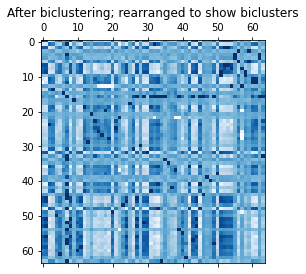

In [79]:
plt.matshow(fit_data, cmap=plt.cm.Blues, vmin=-1, vmax=1)
plt.title("After biclustering; rearranged to show biclusters")

#### hierarchical clustering

In [84]:
from scipy.stats import spearmanr

corr = spearmanr(X).correlation

In [90]:
from scipy.cluster import hierarchy

corr_linkage = hierarchy.ward(corr)
labels = [f"dim{i}" for i in np.arange(64)]
dendro = hierarchy.dendrogram(
    corr_linkage, labels=labels, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

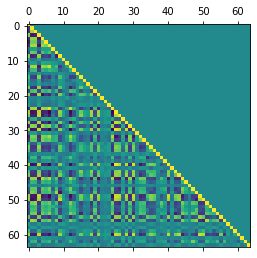

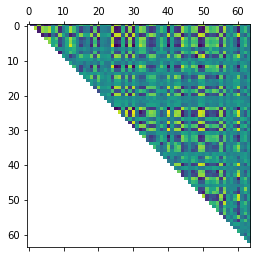

In [115]:
# plt.matshow(np.tril(corr))

# cp = np.copy(corr)
# cp[np.tril_indices(64)] = np.nan
# plt.matshow(cp)

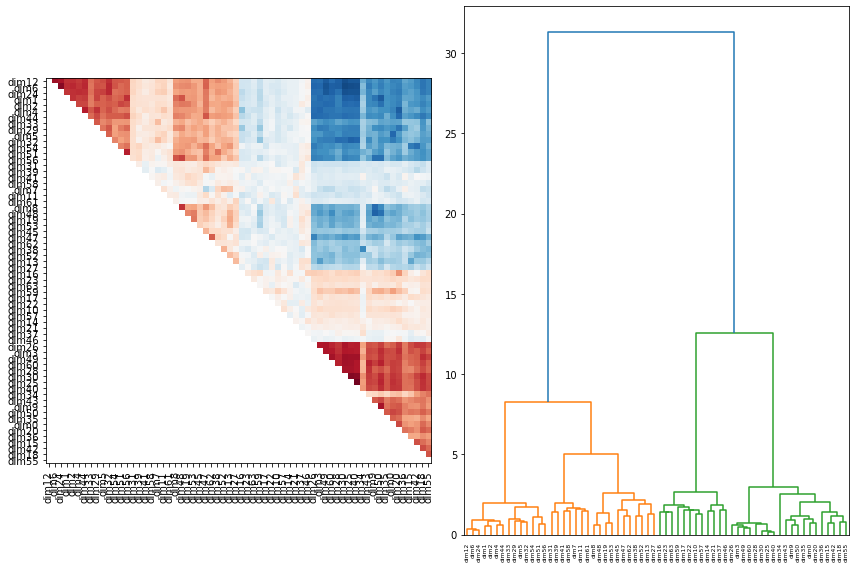

In [118]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 8))

labels = [f"dim{i}" for i in np.arange(64)]
dendro = hierarchy.dendrogram(
    corr_linkage, labels=labels,ax=ax2, leaf_rotation=90
)

cp = np.copy(corr[dendro['leaves'], :][:, dendro['leaves']])
cp[np.tril_indices(64)] = np.nan
im = ax.imshow(cp, cmap="RdBu_r", vmin=-1, vmax=1)

# cax = fig.add_axes([0., 0., 0.5, 0.02])
# plt.colorbar(im, label="Correlation Coefficient")
# fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_xticks(dendro_idx)
ax.set_yticks(dendro_idx)
ax.set_xticklabels(dendro['ivl'], rotation='vertical')
ax.set_yticklabels(dendro['ivl'])

fig.tight_layout()
plt.show()

# Correlation matrix of C64 with Q, P, T

# Correlation matrix of C64 with static inputs ....?